# Imports

In [1]:
!pip install numpy==1.24.4
!pip uninstall matplotlib -y
!pip install matplotlib==3.7.2

Defaulting to user installation because normal site-packages is not writeable
Found existing installation: matplotlib 3.7.2
Uninstalling matplotlib-3.7.2:
ERROR: Exception:
Traceback (most recent call last):
  File "/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/shutil.py", line 825, in move
    os.rename(src, real_dst)
OSError: [Errno 18] Invalid cross-device link: '/sfs/applications/202412/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/__pycache__/pylab.cpython-311.pyc' -> '/tmp/pip-uninstall-91wngz_p/pylab.cpython-311.pyc'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/cbv6gd/.local/lib/python3.11/site-packages/pip/_internal/cli/base_command.py", line 105, in _run_wrapper
    status = _inner_run()
             ^^^^^^^^^^^^
  File "/home/cbv6gd/.local/lib/python3.11/site-packages/pip/_internal/cli/base_command.py", line 96, in _inner_run
    return self.run(option

In [3]:
## Standard Library
import os
import shutil
import joblib

## Data Handling
import pandas as pd
import numpy as np
import random

## MLMs and Preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_class_weight

## XGBoost
from xgboost import XGBClassifier

## Deep Learning (TensorFlow + Keras)
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, MultiHeadAttention
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

## SHAP
import shap

## Visualization
import matplotlib.pyplot as plt

## Set seeds for reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Force TensorFlow to be deterministic
os.environ['TF_DETERMINISTIC_OPS'] = '1'

## Disable GPU parallelism randomness
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

NumPy version: 1.24.4
Matplotlib version: 3.7.2


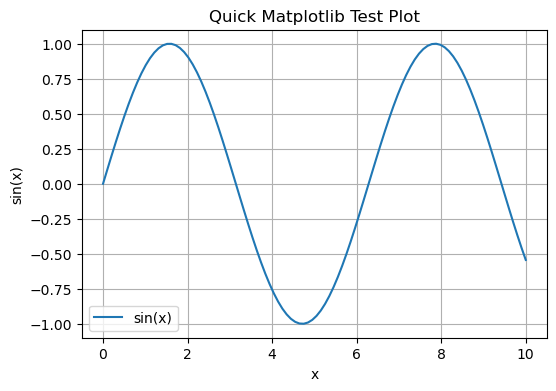

In [4]:
## Test Cell: Check NumPy and Matplotlib installation

## Print versions to confirm
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

## Tiny plot to confirm full functionality
x = np.linspace(0, 10, 100)
y = np.sin(x)

plt.figure(figsize=(6, 4))
plt.plot(x, y, label='sin(x)')
plt.title('Quick Matplotlib Test Plot')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.legend()
plt.grid(True)
plt.show()

# Data Loading and Basic Preprocessing

In [5]:
## Load the full matchups dataset
full_matchups = pd.read_csv('nba_game_logs.csv')

## Convert GAME_DATE to datetime format
full_matchups['GAME_DATE'] = pd.to_datetime(full_matchups['GAME_DATE'])

## Sort by team and game date
full_matchups = full_matchups.sort_values(by=['TEAM_ABBREVIATION', 'GAME_DATE'])

# Rolling 5-Game Statistics

In [6]:
## Create Rolling 5-Game Player-Level Averages (shifted)
rolling_columns = [
    'PTS', 'AST', 'REB', 'STL', 'BLK', 'FGM', 'FGA',
    'FG3M', 'FG3A', 'FTM', 'FTA', 'TO'
]

for col in rolling_columns:
    full_matchups[f'{col}_rolling_5'] = (
        full_matchups
        .groupby('TEAM_ABBREVIATION')[col]
        .shift(1)
        .rolling(window=5, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )

# Season-to-Date Statistics

In [7]:
## Create Season-to-Date Player-Level Averages (shifted)
season_avg_columns = [
    'PTS', 'AST', 'REB', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA'
]

for col in season_avg_columns:
    full_matchups[f'{col}_season_avg'] = (
        full_matchups
        .groupby('TEAM_ABBREVIATION')[col]
        .expanding()
        .mean()
        .shift(1)
        .reset_index(level=0, drop=True)
    )

# Aggregate Player Stats to Team Level

In [8]:
aggregation_dict = {f'{col}_rolling_5': 'sum' for col in rolling_columns}
aggregation_dict.update({f'{col}_season_avg': 'sum' for col in season_avg_columns})

team_stats = (
    full_matchups
    .groupby(['GAME_ID', 'TEAM_ABBREVIATION'])
    .agg(aggregation_dict)
    .reset_index()
)

# Merging Game Info

In [9]:
game_info = full_matchups[
    ['GAME_ID', 'GAME_DATE', 'WINNER_ABBR',
     'HOME_TEAM_ABBR', 'AWAY_TEAM_ABBR',
     'GAME_LOCATION', 'HOME_SCORE', 'AWAY_SCORE',
     'HOME_WIN', 'AWAY_WIN'
    ]
].drop_duplicates(subset='GAME_ID')

team_stats = team_stats.merge(game_info, on='GAME_ID', how='left')

# Feature Engineering

In [10]:
## Win/Loss Label
team_stats['WL'] = (team_stats['WINNER_ABBR'] == team_stats['TEAM_ABBREVIATION']).astype(int)

## Home Team Indicator
team_stats['IS_HOME_TEAM'] = (team_stats['TEAM_ABBREVIATION'] == team_stats['HOME_TEAM_ABBR']).astype(int)

## Sort for Rolling Features
team_stats = team_stats.sort_values(by=['TEAM_ABBREVIATION', 'GAME_DATE'])

## Rolling Win Rate
team_stats['WIN_rolling_5'] = (
    team_stats.groupby('TEAM_ABBREVIATION')['WL']
    .shift(1)
    .rolling(window=5, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

## Team Point Differential
team_stats['POINT_DIFF'] = team_stats['HOME_SCORE'] - team_stats['AWAY_SCORE']

def assign_team_point_diff(row):
    if row['TEAM_ABBREVIATION'] == row['HOME_TEAM_ABBR']:
        return row['POINT_DIFF']
    else:
        return -row['POINT_DIFF']

team_stats['TEAM_POINT_DIFF'] = team_stats.apply(assign_team_point_diff, axis=1)

## Rolling Point Differential
team_stats['TEAM_POINT_DIFF_rolling_5'] = (
    team_stats.groupby('TEAM_ABBREVIATION')['TEAM_POINT_DIFF']
    .shift(1)
    .rolling(window=5, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

## Turnover Ratio
team_stats['TO_RATIO'] = team_stats['TO_rolling_5'] / (team_stats['FGA_rolling_5'] + 1e-5)

## Effective Field Goal %
team_stats['eFG_PCT'] = (team_stats['FGM_rolling_5'] + 0.5 * team_stats['FG3M_rolling_5']) / (team_stats['FGA_rolling_5'] + 1e-5)

## Opponent Rolling Win Rate
team_win_rate_map = team_stats.set_index(['GAME_ID', 'TEAM_ABBREVIATION'])['WIN_rolling_5']

def get_opp_win_rate(row):
    opp_team = row['AWAY_TEAM_ABBR'] if row['TEAM_ABBREVIATION'] == row['HOME_TEAM_ABBR'] else row['HOME_TEAM_ABBR']
    return team_win_rate_map.get((row['GAME_ID'], opp_team), np.nan)

team_stats['OPP_WIN_rolling_5'] = team_stats.apply(get_opp_win_rate, axis=1)

## Relative Win Rate (Own - Opponent)
team_stats['RELATIVE_WIN_RATE'] = team_stats['WIN_rolling_5'] - team_stats['OPP_WIN_rolling_5']

## Days Since Last Game
team_stats['DAYS_SINCE_LAST_GAME'] = (
    team_stats.groupby('TEAM_ABBREVIATION')['GAME_DATE']
    .diff()
    .dt.days
    .fillna(7)
    .clip(upper=7)
)

## Drop Helper Columns
team_stats = team_stats.drop(columns=['POINT_DIFF'])

# Cleaning NaNs and Final Data Prep

In [11]:
## Drop Any NaNs in Final Key Columns
team_stats = team_stats.dropna(subset=[
    'HOME_TEAM_ABBR', 'AWAY_TEAM_ABBR', 
    'WIN_rolling_5', 'TEAM_POINT_DIFF_rolling_5', 
    'OPP_WIN_rolling_5'
])

# Save Final Dataset

In [12]:
## Save cleaned dataset
team_stats.to_csv('rolling_5_matchups.csv', index=False)

# Create Sequence Data, Feature, and Target

In [14]:
## Define feature columns (the 28 engineered features)
feature_columns = [
    'PTS_rolling_5', 'AST_rolling_5', 'REB_rolling_5', 'STL_rolling_5',
    'BLK_rolling_5', 'FGM_rolling_5', 'FGA_rolling_5', 'FG3A_rolling_5',
    'FG3M_rolling_5', 'FTM_rolling_5', 'FTA_rolling_5', 'IS_HOME_TEAM',
    'WIN_rolling_5', 'TEAM_POINT_DIFF_rolling_5', 'TO_RATIO', 'eFG_PCT',
    'PTS_season_avg', 'AST_season_avg', 'REB_season_avg', 'FGM_season_avg',
    'FGA_season_avg', 'FG3M_season_avg', 'FG3A_season_avg', 'FTM_season_avg', 'FTA_season_avg',
    'OPP_WIN_rolling_5', 'RELATIVE_WIN_RATE', 'DAYS_SINCE_LAST_GAME'
]

target_column = 'WL'

## Extract feature matrix (X) and target (y) from team_stats
X = team_stats[feature_columns]
y = team_stats[target_column]

# Train-Test Split

In [15]:
## Create sequences (5 games history → predict next WL)
window_size = 5
X_sequences = []
y_sequences = []

for team, group in team_stats.groupby('TEAM_ABBREVIATION'):
    group = group.sort_values('GAME_DATE')
    group = group.dropna(subset=feature_columns + ['WL'])  # Drop NaNs
    features = group[feature_columns].values
    labels = group['WL'].values

    for i in range(window_size, len(features)):
        X_sequences.append(features[i-window_size:i])
        y_sequences.append(labels[i])  # Label is WL of NEXT game

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

print(f"X_sequences shape: {X_sequences.shape}")
print(f"y_sequences shape: {y_sequences.shape}")

X_sequences shape: (24191, 5, 28)
y_sequences shape: (24191,)


# Feature Scaling

In [16]:
# Flatten X_sequences for models like Logistic Regression, Random Forest
n_samples, n_timesteps, n_features = X_sequences.shape
X_flat = X_sequences.reshape(n_samples, n_timesteps * n_features)

# Standardize features
scaler = StandardScaler()
X_flat_scaled = scaler.fit_transform(X_flat)

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

# Logistic Regression (Baseline Model)

In [18]:
# Logistic Regression Cross-Validation
logreg = LogisticRegression(max_iter=1000, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_y_true = []
all_y_pred = []

for train_idx, test_idx in cv.split(X_flat_scaled, y_sequences):
    X_train_cv, X_test_cv = X_flat_scaled[train_idx], X_flat_scaled[test_idx]
    y_train_cv, y_test_cv = y_sequences[train_idx], y_sequences[test_idx]
    
    logreg.fit(X_train_cv, y_train_cv)
    preds = logreg.predict(X_test_cv)
    
    all_y_true.extend(y_test_cv)
    all_y_pred.extend(preds)

y_pred_logreg = np.array(all_y_pred)
y_true_logreg = np.array(all_y_true)

print("Cross-Validated Classification Report (Logistic Regression):")
print(classification_report(all_y_true, all_y_pred))
print(f"Overall Accuracy (Random Forest): {accuracy_score(all_y_true, all_y_pred):.4f}")

Cross-Validated Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.54      0.56      0.55     12096
           1       0.54      0.53      0.54     12095

    accuracy                           0.54     24191
   macro avg       0.54      0.54      0.54     24191
weighted avg       0.54      0.54      0.54     24191

Overall Accuracy (Random Forest): 0.5432


# Random Forest

In [19]:
## Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

## Storage
all_y_true_rf = []
all_y_pred_rf = []

## CV loop
for train_idx, test_idx in cv.split(X_flat_scaled, y_sequences):
    X_train, X_test = X_flat_scaled[train_idx], X_flat_scaled[test_idx]
    y_train, y_test = y_sequences[train_idx], y_sequences[test_idx]
    
    rf_model.fit(X_train, y_train)
    preds = rf_model.predict(X_test)
    
    all_y_true_rf.extend(y_test)
    all_y_pred_rf.extend(preds)

print("Cross-Validated Classification Report (Random Forest):")
print(classification_report(all_y_true_rf, all_y_pred_rf))
print(f"Overall Accuracy (Random Forest): {accuracy_score(all_y_true_rf, all_y_pred_rf):.4f}")

Cross-Validated Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.55      0.58      0.56     12096
           1       0.56      0.53      0.54     12095

    accuracy                           0.55     24191
   macro avg       0.55      0.55      0.55     24191
weighted avg       0.55      0.55      0.55     24191

Overall Accuracy (Random Forest): 0.5534


# Stacked Model

In [20]:
## Define base learners
base_learners = [
    ('logreg', LogisticRegression(max_iter=1000, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42))
]

## Meta-learner
meta_learner = LogisticRegression(max_iter=1000, random_state=42)

## Stacking classifier
stacking_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    passthrough=False,
    n_jobs=-1
)

## Storage
all_y_true_stack = []
all_y_pred_stack = []

## CV loop
for train_idx, test_idx in cv.split(X_flat_scaled, y_sequences):
    X_train, X_test = X_flat_scaled[train_idx], X_flat_scaled[test_idx]
    y_train, y_test = y_sequences[train_idx], y_sequences[test_idx]
    
    stacking_model.fit(X_train, y_train)
    preds = stacking_model.predict(X_test)
    
    all_y_true_stack.extend(y_test)
    all_y_pred_stack.extend(preds)

print("Cross-Validated Classification Report (Stacked Ensemble):")
print(classification_report(all_y_true_stack, all_y_pred_stack))
print(f"Overall Accuracy (Stacked Ensemble): {accuracy_score(all_y_true_stack, all_y_pred_stack):.4f}")

Cross-Validated Classification Report (Stacked Ensemble):
              precision    recall  f1-score   support

           0       0.48      0.47      0.47     12096
           1       0.48      0.49      0.49     12095

    accuracy                           0.48     24191
   macro avg       0.48      0.48      0.48     24191
weighted avg       0.48      0.48      0.48     24191

Overall Accuracy (Stacked Ensemble): 0.4812


# XGBoost

In [21]:
## Model
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

## Storage
all_y_true_xgb = []
all_y_pred_xgb = []

## CV loop
for train_idx, test_idx in cv.split(X_flat_scaled, y_sequences):
    X_train, X_test = X_flat_scaled[train_idx], X_flat_scaled[test_idx]
    y_train, y_test = y_sequences[train_idx], y_sequences[test_idx]
    
    xgb_model.fit(X_train, y_train)
    preds = xgb_model.predict(X_test)
    
    all_y_true_xgb.extend(y_test)
    all_y_pred_xgb.extend(preds)

print("Cross-Validated Classification Report (XGBoost):")
print(classification_report(all_y_true_xgb, all_y_pred_xgb))
print(f"Overall Accuracy (XGBoost): {accuracy_score(all_y_true_xgb, all_y_pred_xgb):.4f}")

/home/cbv6gd/.local/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:50:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/cbv6gd/.local/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:50:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Cross-Validated Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.56      0.54      0.55     12096
           1       0.55      0.57      0.56     12095

    accuracy                           0.56     24191
   macro avg       0.56      0.56      0.56     24191
weighted avg       0.56      0.56      0.56     24191

Overall Accuracy (XGBoost): 0.5557


# Neural Network with KerasTuner

In [25]:
## Model building function
def build_nn_model(hp):
    model = Sequential()
    
    neurons = hp.Int('neurons', min_value=32, max_value=128, step=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    num_layers = hp.Int('num_layers', min_value=2, max_value=4)
    activation = hp.Choice('activation', ['relu', 'tanh'])
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')

    # Input layer
    model.add(Dense(neurons, input_dim=X_flat_scaled.shape[1], activation=activation))

    # Hidden layers
    for _ in range(num_layers - 1):
        model.add(Dense(neurons, activation=activation))
        model.add(Dropout(dropout_rate))
        
    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer setup
    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

## Clean up previous tuner directory
tuner_dir = 'keras_tuner_dir/nn_tuning'
if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)

## Set up KerasTuner
tuner = kt.RandomSearch(
    build_nn_model,
    objective='val_accuracy',
    max_trials=50,
    executions_per_trial=1,
    overwrite=True,
    directory='keras_tuner_dir',
    project_name='nn_tuning'
)

## Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

## Start search
tuner.search(
    X_flat_scaled, y_sequences,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

## Get best model
best_nn_model = tuner.get_best_models(1)[0]

## Predict and evaluate
y_pred_nn = (best_nn_model.predict(X_flat_scaled) > 0.5).astype(int).flatten()

print(f"Tuned NN Accuracy: {accuracy_score(y_sequences, y_pred_nn):.4f}")
print("Classification Report:\n", classification_report(y_sequences, y_pred_nn))

Trial 50 Complete [00h 00m 05s]
val_accuracy: 0.5046496987342834

Best val_accuracy So Far: 0.511469304561615
Total elapsed time: 00h 05m 30s
172/756 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step

/home/cbv6gd/.local/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-04-28 21:57:25.924252: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 623us/step
Tuned NN Accuracy: 0.6208
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.63      0.62     12096
           1       0.62      0.61      0.62     12095

    accuracy                           0.62     24191
   macro avg       0.62      0.62      0.62     24191
weighted avg       0.62      0.62      0.62     24191



# Transformer Model with KerasTuner

In [27]:
## Train/test split FIRST
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_sequences, y_sequences, test_size=0.2, random_state=42, stratify=y_sequences
)

## Compute class weights
class_weights = dict(enumerate(
    compute_class_weight(class_weight='balanced', classes=np.unique(y_train_seq), y=y_train_seq)
))

## Define Transformer model builder
def build_transformer_model_tuner(hp):
    inputs = Input(shape=(X_sequences.shape[1], X_sequences.shape[2]))
    
    num_heads = hp.Choice('num_heads', values=[2, 4])
    key_dim = hp.Choice('key_dim', values=[16, 32, 64])
    
    x = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)
    x = Dropout(hp.Float('attention_dropout', 0.2, 0.4, step=0.1))(x)
    x = Flatten()(x)
    
    dense_units = hp.Int('dense_units', min_value=64, max_value=128, step=32)  # Moderate
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(hp.Float('dense_dropout', 0.2, 0.4, step=0.1))(x)
    
    outputs = Dense(1, activation='sigmoid')(x)
    
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

## Clean tuner directory
transformer_tuner_dir = 'keras_tuner_dir/transformer_tuning'
if os.path.exists(transformer_tuner_dir):
    shutil.rmtree(transformer_tuner_dir)

## Initialize tuner
transformer_tuner = kt.RandomSearch(
    build_transformer_model_tuner,
    objective='val_accuracy',
    max_trials=30,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='transformer_tuning'
)

## Early Stopping and LR Scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

## Train/test split
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_sequences, y_sequences, test_size=0.2, random_state=42, stratify=y_sequences
)

## Launch tuner search
transformer_tuner.search(
    X_train_seq, y_train_seq,
    epochs=75,
    batch_size=64,
    validation_data=(X_test_seq, y_test_seq),
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

## Get best model
best_transformer_model = transformer_tuner.get_best_models(1)[0]

## Evaluate
y_pred_transformer = best_transformer_model.predict(X_test_seq)
y_pred_transformer = (y_pred_transformer > 0.5).astype(int).flatten()

print(f"Tuned Transformer Test Accuracy: {accuracy_score(y_test_seq, y_pred_transformer):.4f}")
print("Classification Report (Tuned Transformer):\n")
print(classification_report(y_test_seq, y_pred_transformer))

## Save model
best_transformer_model.save('best_transformer_model.h5')

Trial 30 Complete [00h 00m 37s]
val_accuracy: 0.5001033544540405

Best val_accuracy So Far: 0.549493670463562
Total elapsed time: 00h 14m 50s
 38/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

/home/cbv6gd/.local/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-04-28 22:14:14.699954: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Tuned Transformer Test Accuracy: 0.5495
Classification Report (Tuned Transformer):

              precision    recall  f1-score   support

           0       0.56      0.48      0.52      2420
           1       0.54      0.62      0.58      2419

    accuracy                           0.55      4839
   macro avg       0.55      0.55      0.55      4839
weighted avg       0.55      0.55      0.55      4839



In [48]:
accuracy_score(y_test_seq, y_pred_transformer)

0.5387476751394916

# Model Accuracy Comparison Plot

In [28]:
# Logistic Regression
y_pred_logreg = np.array(all_y_pred)
y_true_logreg = np.array(all_y_true)

# Random Forest
y_pred_rf = np.array(all_y_pred_rf)
y_true_rf = np.array(all_y_true_rf)

# Stacking (no XGB)
y_pred_stacking = np.array(all_y_pred_stack)
y_true_stacking = np.array(all_y_true_stack)

# Tuned Neural Network
y_pred_nn = (best_nn_model.predict(X_flat_scaled) > 0.5).astype(int).flatten()
y_true_nn = y_sequences  # already aligned earlier

# Tuned Transformer
y_pred_transformer = (best_transformer_model.predict(X_sequences) > 0.5).astype(int).flatten()
y_true_transformer = y_sequences  # same

255/756 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step

2025-04-28 22:14:46.867741: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


756/756 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


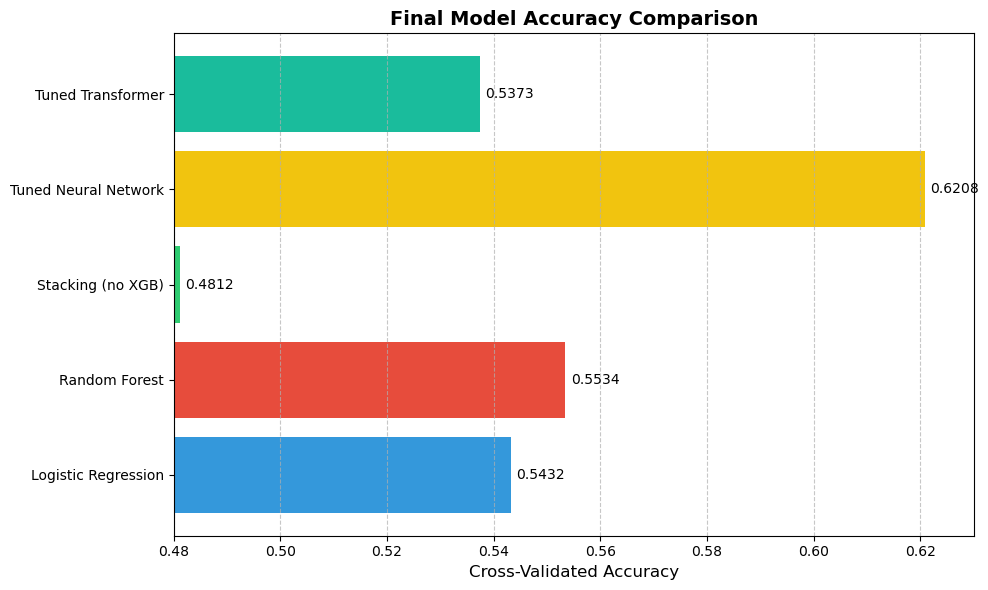

In [30]:
model_names = [
    'Logistic Regression',
    'Random Forest',
    'Stacking (no XGB)',
    'Tuned Neural Network',
    'Tuned Transformer'
]

model_accuracies = [
    accuracy_score(y_true_logreg, y_pred_logreg),
    accuracy_score(y_true_rf, y_pred_rf),
    accuracy_score(y_true_stacking, y_pred_stacking),
    accuracy_score(y_true_nn, y_pred_nn),
    accuracy_score(y_true_transformer, y_pred_transformer)
]

bar_colors = ['#3498db', '#e74c3c', '#2ecc71', '#f1c40f', '#1abc9c']

# --- Plot ---
plt.figure(figsize=(10, 6))
bars = plt.barh(model_names, model_accuracies, color=bar_colors)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f"{width:.4f}", ha='left', va='center', fontsize=10)

plt.xlabel('Cross-Validated Accuracy', fontsize=12)
plt.title('Final Model Accuracy Comparison', fontsize=14, weight='bold')
plt.xlim(0.48, 0.63)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Learning Curve Plot

Epoch 1/50


2025-04-28 22:16:59.939638: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


605/605 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5761 - loss: 0.6712 - val_accuracy: 0.5764 - val_loss: 0.6717 - learning_rate: 0.0014
Epoch 2/50
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5972 - loss: 0.6642 - val_accuracy: 0.5675 - val_loss: 0.6769 - learning_rate: 0.0014
Epoch 3/50
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6054 - loss: 0.6572 - val_accuracy: 0.5640 - val_loss: 0.6790 - learning_rate: 0.0014
Epoch 4/50
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6164 - loss: 0.6499 - val_accuracy: 0.5551 - val_loss: 0.6858 - learning_rate: 0.0014
Epoch 5/50
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6238 - loss: 0.6402 - val_accuracy: 0.5561 - val_loss: 0.6906 - learning_rate: 0.0014
Epoch 6/50
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6371 - loss: 0.6270 - val_accuracy: 0.5600 - val_loss: 0.6934 - learning_rate: 0.0014
Epoch 7/50
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6558 - loss: 0.6107 - val_accurac

2025-04-28 22:17:08.946049: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


605/605 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5154 - loss: 0.6976 - val_accuracy: 0.5387 - val_loss: 0.6915 - learning_rate: 1.0000e-04
Epoch 2/50
605/605 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5080 - loss: 0.6959 - val_accuracy: 0.5024 - val_loss: 0.6923 - learning_rate: 1.0000e-04
Epoch 3/50
605/605 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5077 - loss: 0.6950 - val_accuracy: 0.5135 - val_loss: 0.6924 - learning_rate: 1.0000e-04
Epoch 4/50
605/605 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5067 - loss: 0.6951 - val_accuracy: 0.5187 - val_loss: 0.6925 - learning_rate: 1.0000e-04
Epoch 5/50
605/605 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5074 - loss: 0.6938 - val_accuracy: 0.5069 - val_loss: 0.6925 - learning_rate: 1.0000e-04
Epoch 6/50
605/605 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5076 - loss: 0.6931 - val_accuracy: 0.5224 - val_loss: 0.6925 - learning_rate: 1.0000e-04
Epoch 7/50
605/605 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5076 - lo

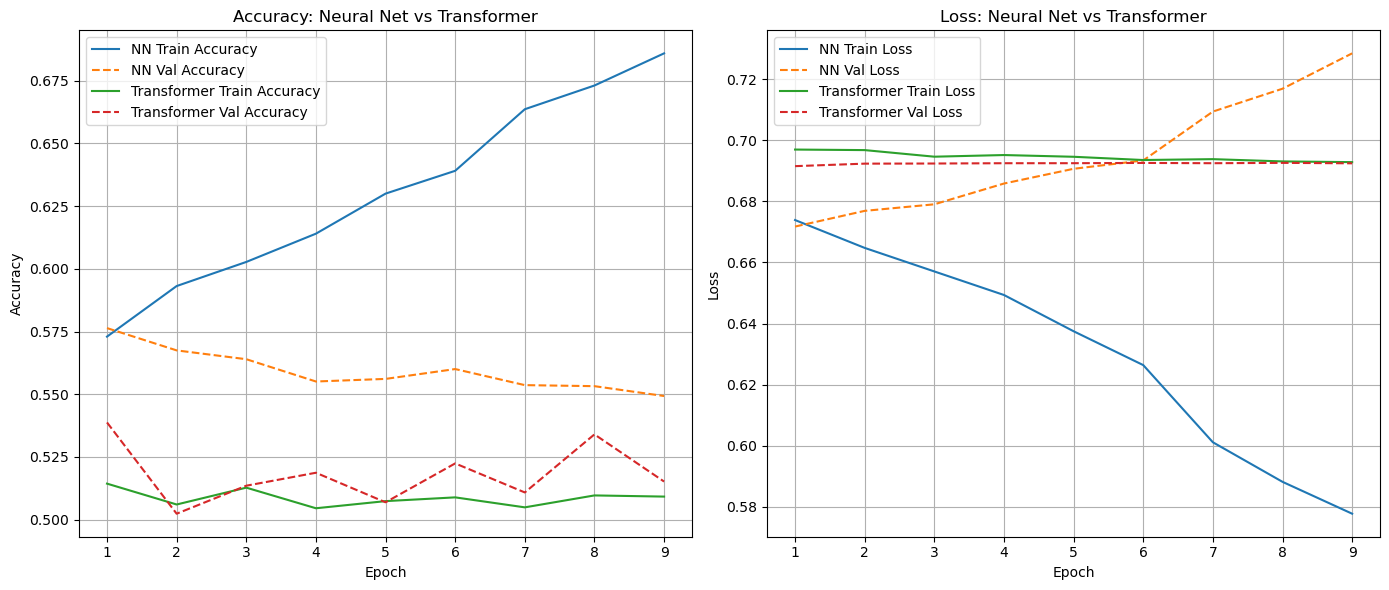

In [33]:
## Flatten sequences for Neural Net
n_samples, n_timesteps, n_features = X_sequences.shape
X_flat = X_sequences.reshape(n_samples, n_timesteps * n_features)

## Train/Test Split for Neural Net
X_train_flat, X_test_flat, y_train_seq, y_test_seq = train_test_split(
    X_flat, y_sequences, test_size=0.2, random_state=42, stratify=y_sequences
)

## Scale for Neural Net
scaler_nn = StandardScaler()
X_train_scaled = scaler_nn.fit_transform(X_train_flat)
X_test_scaled = scaler_nn.transform(X_test_flat)

## Train/Test Split for Transformer (sequential data)
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_sequences, y_sequences, test_size=0.2, random_state=42, stratify=y_sequences
)

## Reshape (no change) for Transformer
X_train_reshaped = X_train_seq
X_test_reshaped = X_test_seq

## Retrain Neural Network
history_nn = best_nn_model.fit(
    X_train_scaled, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_scaled, y_test_seq),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

## Retrain Transformer
history_transformer = best_transformer_model.fit(
    X_train_reshaped, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test_seq),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

## Plot learning curves
epochs_nn = range(1, len(history_nn.history['loss']) + 1)
epochs_transformer = range(1, len(history_transformer.history['loss']) + 1)

plt.figure(figsize=(14, 6))

## Accuracy Comparison
plt.subplot(1, 2, 1)
plt.plot(epochs_nn, history_nn.history['accuracy'], label='NN Train Accuracy', linestyle='-')
plt.plot(epochs_nn, history_nn.history['val_accuracy'], label='NN Val Accuracy', linestyle='--')
plt.plot(epochs_transformer, history_transformer.history['accuracy'], label='Transformer Train Accuracy', linestyle='-')
plt.plot(epochs_transformer, history_transformer.history['val_accuracy'], label='Transformer Val Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy: Neural Net vs Transformer')
plt.legend()
plt.grid(True)

## Loss Comparison
plt.subplot(1, 2, 2)
plt.plot(epochs_nn, history_nn.history['loss'], label='NN Train Loss', linestyle='-')
plt.plot(epochs_nn, history_nn.history['val_loss'], label='NN Val Loss', linestyle='--')
plt.plot(epochs_transformer, history_transformer.history['loss'], label='Transformer Train Loss', linestyle='-')
plt.plot(epochs_transformer, history_transformer.history['val_loss'], label='Transformer Val Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss: Neural Net vs Transformer')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Confusion Matrix for Best Model

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step


2025-04-28 22:19:44.259195: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


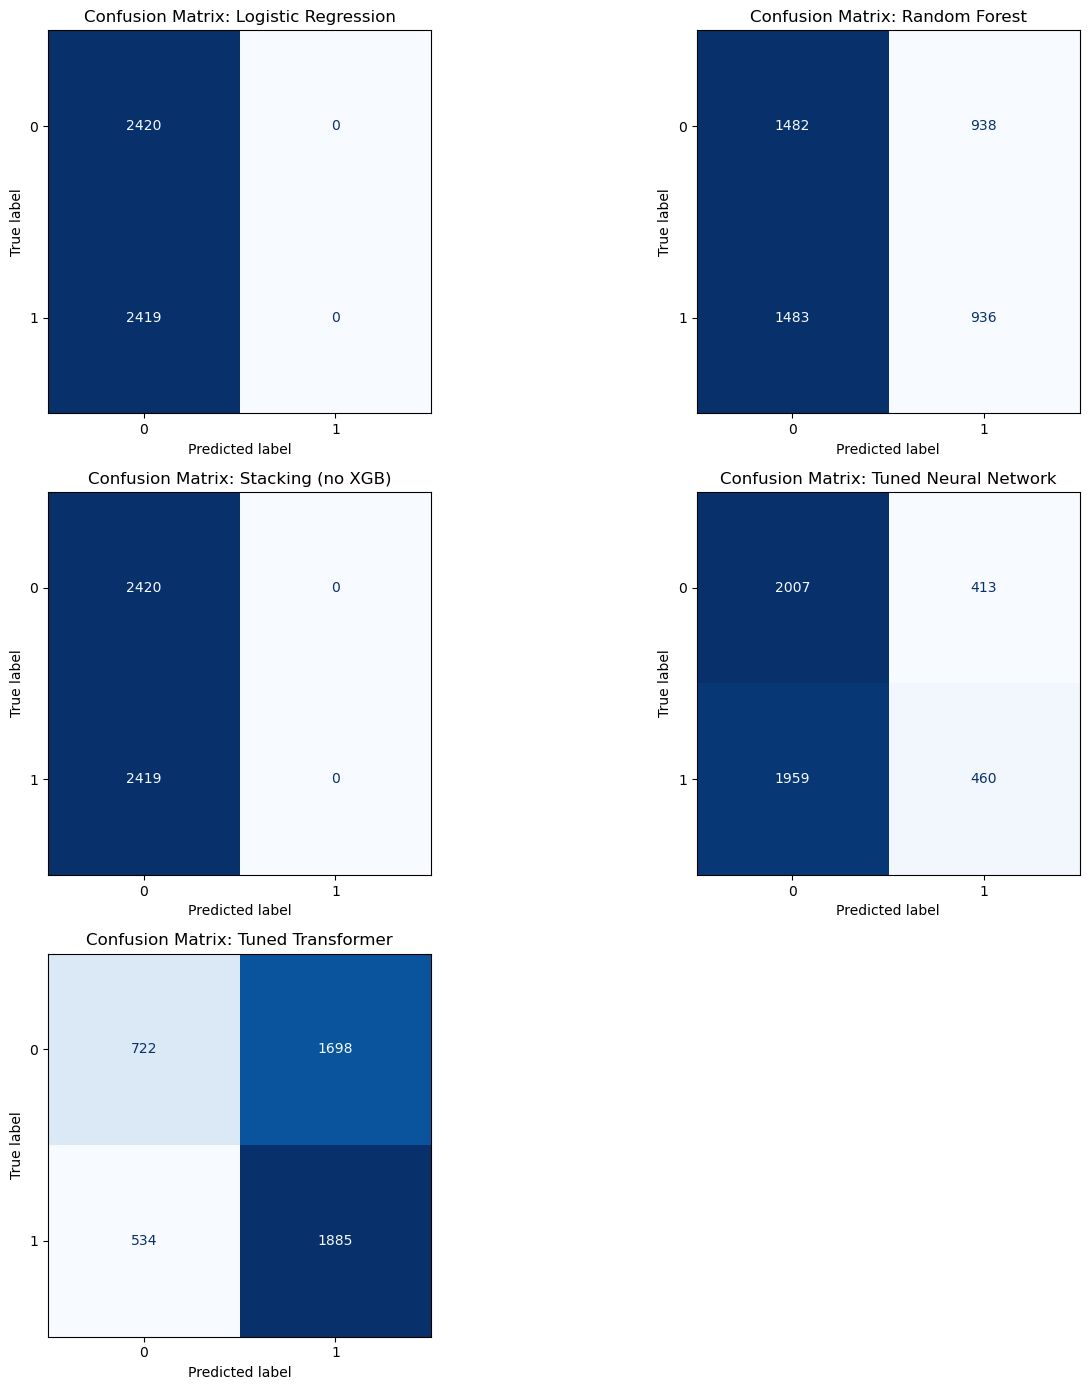

In [35]:
## Logistic Regression
y_pred_logreg = logreg.predict(X_test_flat)

## Random Forest
y_pred_rf = rf_model.predict(X_test_flat)

## Stacking (no XGB)
y_pred_stacking = stacking_model.predict(X_test_flat)

## Tuned Neural Network
y_pred_nn = (best_nn_model.predict(X_test_flat) > 0.5).astype(int).flatten()

## Tuned Transformer
y_pred_transformer = (best_transformer_model.predict(X_test_seq) > 0.5).astype(int).flatten()

## Create model_preds dict
model_preds = {
    'Logistic Regression': y_pred_logreg,
    'Random Forest': y_pred_rf,
    'Stacking (no XGB)': y_pred_stacking,
    'Tuned Neural Network': y_pred_nn,
    'Tuned Transformer': y_pred_transformer
}

## Always use y_test_seq now (since all models predict for test split)
y_truth = y_test_seq

## Plot all confusion matrices
fig, axes = plt.subplots(3, 2, figsize=(14, 14))
axes = axes.flatten()

for ax, (model_name, preds) in zip(axes, model_preds.items()):
    ConfusionMatrixDisplay.from_predictions(
        y_truth, preds,
        cmap='Blues',
        ax=ax,
        colorbar=False
    )
    ax.set_title(f'Confusion Matrix: {model_name}', fontsize=12)
    ax.grid(False)

## Hide extra subplot if any
if len(model_preds) < len(axes):
    for i in range(len(model_preds), len(axes)):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# ROC Curves

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


2025-04-28 22:20:37.344151: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


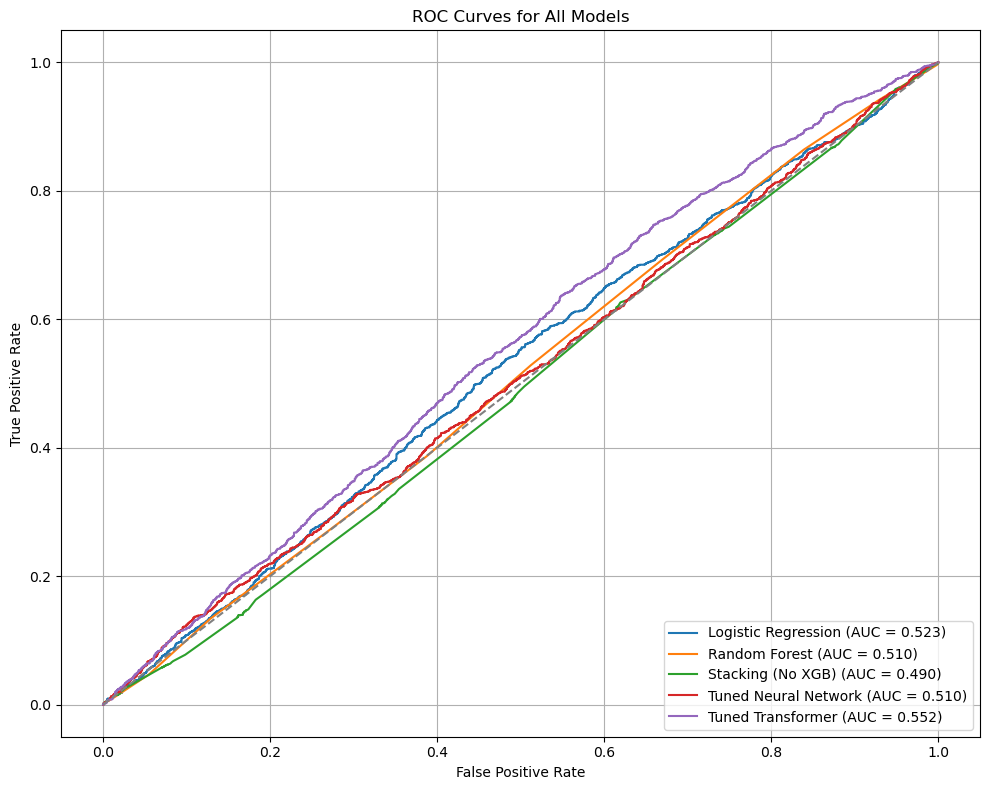

In [37]:
## Store model names and predicted probabilities
model_probs = {
    'Logistic Regression': logreg.predict_proba(X_test_flat)[:, 1],
    'Random Forest': rf_model.predict_proba(X_test_flat)[:, 1],
    'Stacking (No XGB)': stacking_model.predict_proba(X_test_flat)[:, 1],
    'Tuned Neural Network': best_nn_model.predict(X_test_flat).flatten(),
    'Tuned Transformer': best_transformer_model.predict(X_test_seq).flatten()
}

## Plot ROC curves
plt.figure(figsize=(10, 8))

for model_name, probs in model_probs.items():
    fpr, tpr, _ = roc_curve(y_test_seq, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')

## Plot baseline
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

## Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature Importances from Random Forest

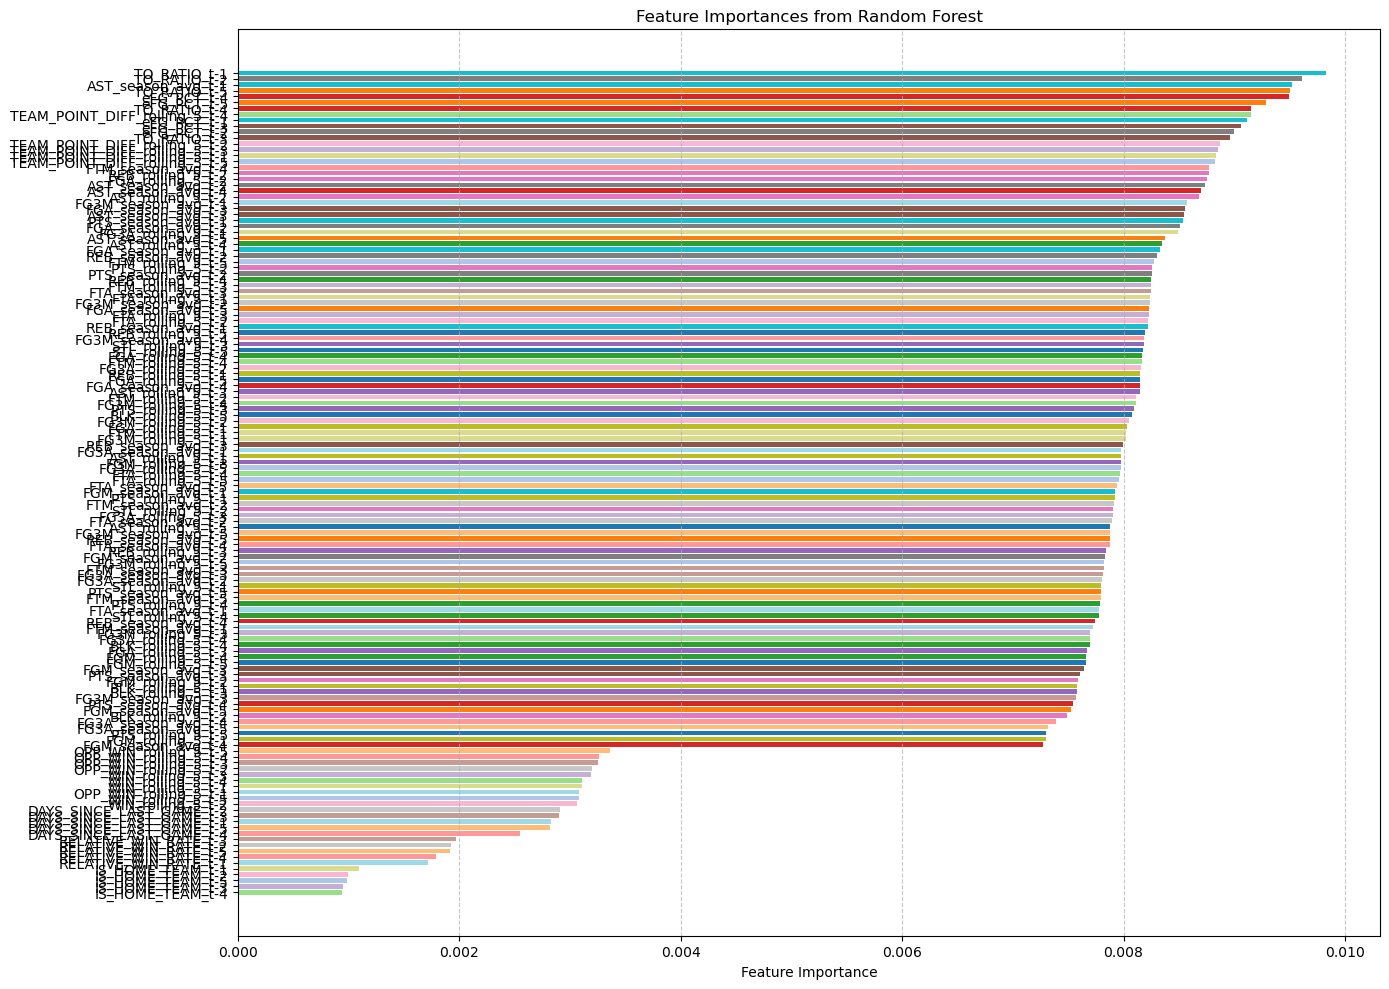

In [39]:
## Extract feature importances
importances = rf_model.feature_importances_

## Feature names (flattened input, so recover original feature names for windowed data)
# For now we'll just use generic names
n_features_per_step = X_sequences.shape[2]
window_size = X_sequences.shape[1]
flattened_feature_names = []

for step in range(window_size):
    for name in feature_columns:
        flattened_feature_names.append(f"{name}_t-{window_size - step}")

feature_names = np.array(flattened_feature_names)

## Sort by importance
sorted_idx = np.argsort(importances)

## Define a color map
colors = plt.cm.tab20(np.linspace(0, 1, len(feature_names)))

## Plot
plt.figure(figsize=(14, 10))
plt.barh(
    feature_names[sorted_idx], 
    importances[sorted_idx], 
    color=colors[sorted_idx]
)
plt.xlabel('Feature Importance')
plt.title('Feature Importances from Random Forest')

## Grid settings
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().xaxis.grid(True)
plt.gca().yaxis.grid(False)

plt.tight_layout()
plt.show()

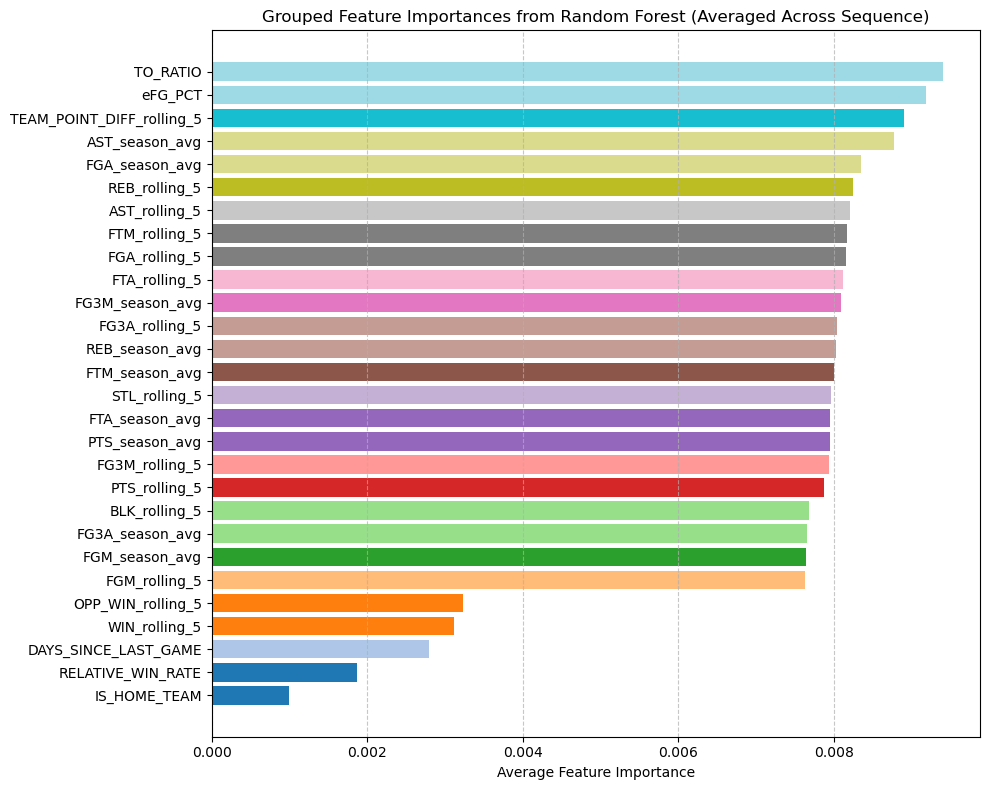

In [40]:
# Create mapping: strip the time step suffix
base_feature_names = [name.split('_t-')[0] for name in feature_names]

# Build DataFrame
importances_df = pd.DataFrame({
    'feature': base_feature_names,
    'importance': importances
})

# Group by base feature name and take mean importance
grouped_importances = importances_df.groupby('feature')['importance'].mean().sort_values()

## Define colors
colors = plt.cm.tab20(np.linspace(0, 1, len(grouped_importances)))

## Plot
plt.figure(figsize=(10, 8))
plt.barh(
    grouped_importances.index,
    grouped_importances.values,
    color=colors
)

plt.xlabel('Average Feature Importance')
plt.title('Grouped Feature Importances from Random Forest (Averaged Across Sequence)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().xaxis.grid(True)
plt.gca().yaxis.grid(False)

plt.tight_layout()
plt.show()

# Feature Importances from XGBoost

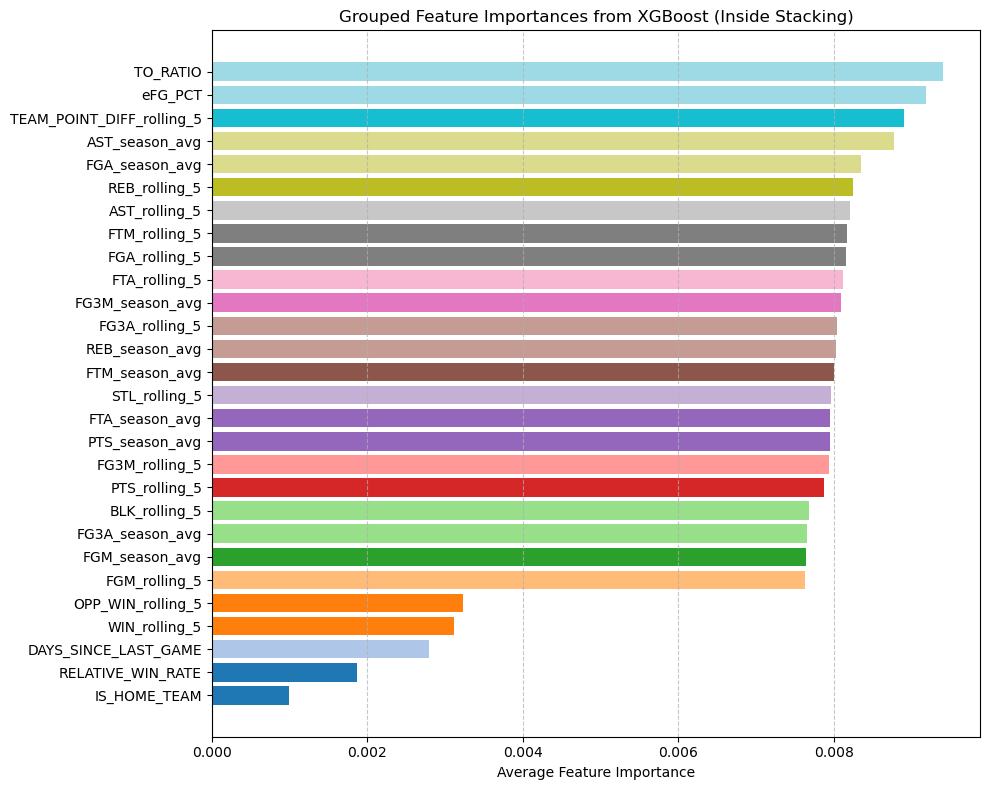

In [42]:
## Extract trained XGBoost model from stacking
xgb_model_inside_stack = stacking_model.named_estimators_['rf']  # <-- fix: should be the real XGBoost inside your stacking

## Get feature importances
xgb_importances = xgb_model_inside_stack.feature_importances_

## Use correct feature names (matching training data)
feature_names = [f"{feat}_t-{i}" for i in range(5, 0, -1) for feat in feature_columns]

## Confirm dimensions match
assert len(xgb_importances) == len(feature_names), "Mismatch between importances and feature names."

## Group feature names by their base name
base_feature_names = [name.split('_t-')[0] for name in feature_names]

## Build DataFrame
importances_df = pd.DataFrame({
    'feature': base_feature_names,
    'importance': xgb_importances
})

## Group by feature and average
grouped_importances = importances_df.groupby('feature')['importance'].mean().sort_values()

## Define color map
colors = plt.cm.tab20(np.linspace(0, 1, len(grouped_importances)))

# Plot
plt.figure(figsize=(10, 8))
plt.barh(
    grouped_importances.index,
    grouped_importances.values,
    color=colors
)

plt.xlabel('Average Feature Importance')
plt.title('Grouped Feature Importances from XGBoost (Inside Stacking)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().xaxis.grid(True)
plt.gca().yaxis.grid(False)

plt.tight_layout()
plt.show()

# Permutation Importance from Transformer

119/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2025-04-28 22:47:59.531480: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
120/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2025-04-28 22:48:04.573479: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


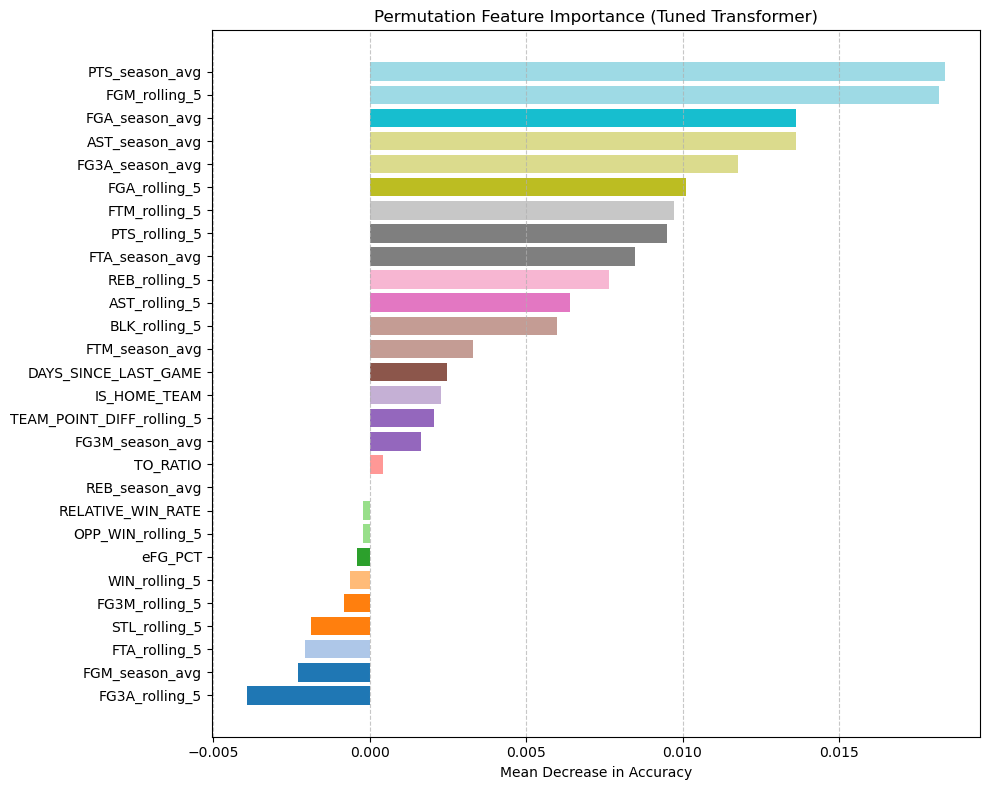

In [49]:
## Copy original accuracy
original_preds = (best_transformer_model.predict(X_test_seq) > 0.5).astype(int).flatten()
original_score = accuracy_score(y_test_seq, original_preds)

## Initialize list
feature_importances = []

## Permute each feature
for i in range(X_test_seq.shape[2]):  # feature dimension
    X_test_permuted = X_test_seq.copy()
    np.random.shuffle(X_test_permuted[:, :, i])  # shuffle feature i across samples

    permuted_preds = (best_transformer_model.predict(X_test_permuted) > 0.5).astype(int).flatten()
    permuted_score = accuracy_score(y_test_seq, permuted_preds)

    importance = original_score - permuted_score
    feature_importances.append(importance)

feature_importances = np.array(feature_importances)

## Sort and plot
sorted_idx = np.argsort(feature_importances)

plt.figure(figsize=(10, 8))
plt.barh(
    np.array(feature_columns)[sorted_idx],
    feature_importances[sorted_idx],
    color=plt.cm.tab20(np.linspace(0, 1, len(feature_columns)))
)
plt.xlabel('Mean Decrease in Accuracy')
plt.title('Permutation Feature Importance (Tuned Transformer)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Permutation Feature Importance

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step


2025-04-28 22:31:59.957102: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
152/152 ━━━

2025-04-28 22:32:05.076436: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
152/152 ━━━

2025-04-28 22:32:10.165147: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
152/152 ━━━

2025-04-28 22:32:15.240916: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step
152/152 ━━━

2025-04-28 22:32:20.344032: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step
152/152 ━━━

2025-04-28 22:32:25.435039: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step


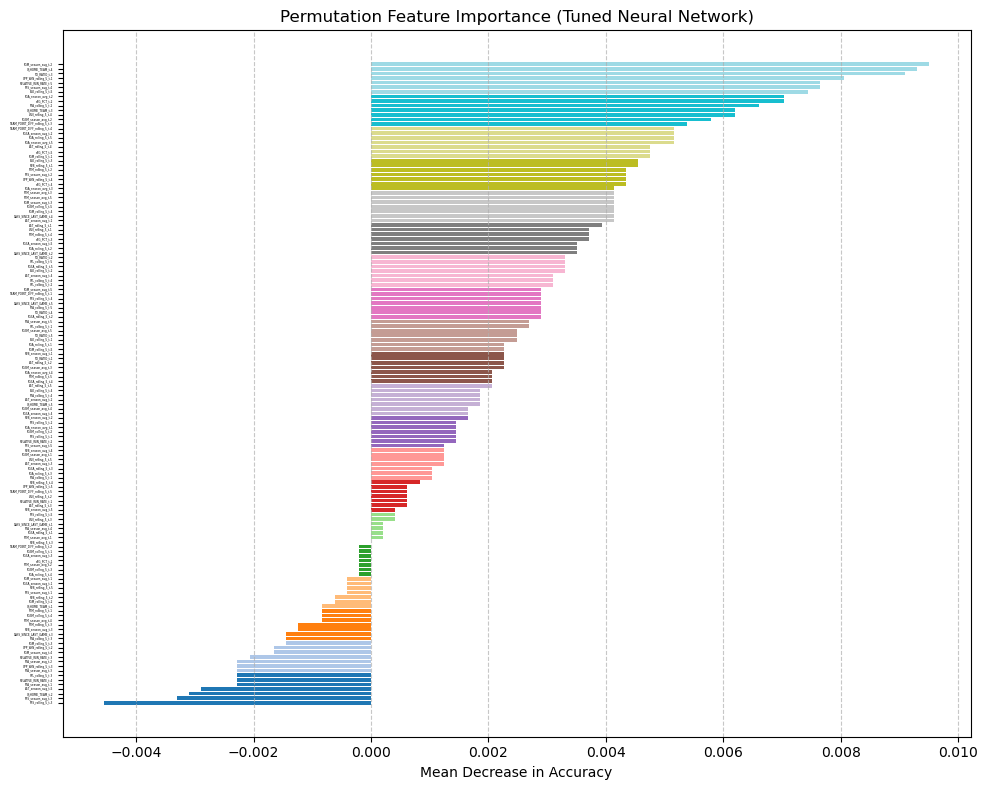

In [47]:
## Build expanded feature names
expanded_feature_names = []
for t in range(window_size):
    for feature in feature_columns:
        expanded_feature_names.append(f'{feature}_t-{window_size - t}')
expanded_feature_names = np.array(expanded_feature_names)

## Copy original accuracy
original_preds = (best_nn_model.predict(X_test_scaled) > 0.5).astype(int).flatten()
original_score = accuracy_score(y_test_seq, original_preds)

## Initialize results
feature_importances = []

## Permute each feature
for i in range(X_test_scaled.shape[1]):
    X_test_permuted = X_test_scaled.copy()
    np.random.shuffle(X_test_permuted[:, i])  # Shuffle column i

    permuted_preds = (best_nn_model.predict(X_test_permuted) > 0.5).astype(int).flatten()
    permuted_score = accuracy_score(y_test_seq, permuted_preds)
    
    importance = original_score - permuted_score
    feature_importances.append(importance)

feature_importances = np.array(feature_importances)

## Sort and plot
sorted_idx = np.argsort(feature_importances)

plt.figure(figsize=(10, 8))
plt.barh(
    np.array(expanded_feature_names)[sorted_idx],  # show full 140 feature names
    feature_importances[sorted_idx],
    color=plt.cm.tab20(np.linspace(0, 1, len(expanded_feature_names)))
)

plt.xlabel('Mean Decrease in Accuracy')
plt.title('Permutation Feature Importance (Tuned Neural Network)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().xaxis.grid(True)
plt.gca().yaxis.grid(False)

## Set smaller font size for y-axis labels
plt.yticks(fontsize=2)

plt.tight_layout()
plt.show()

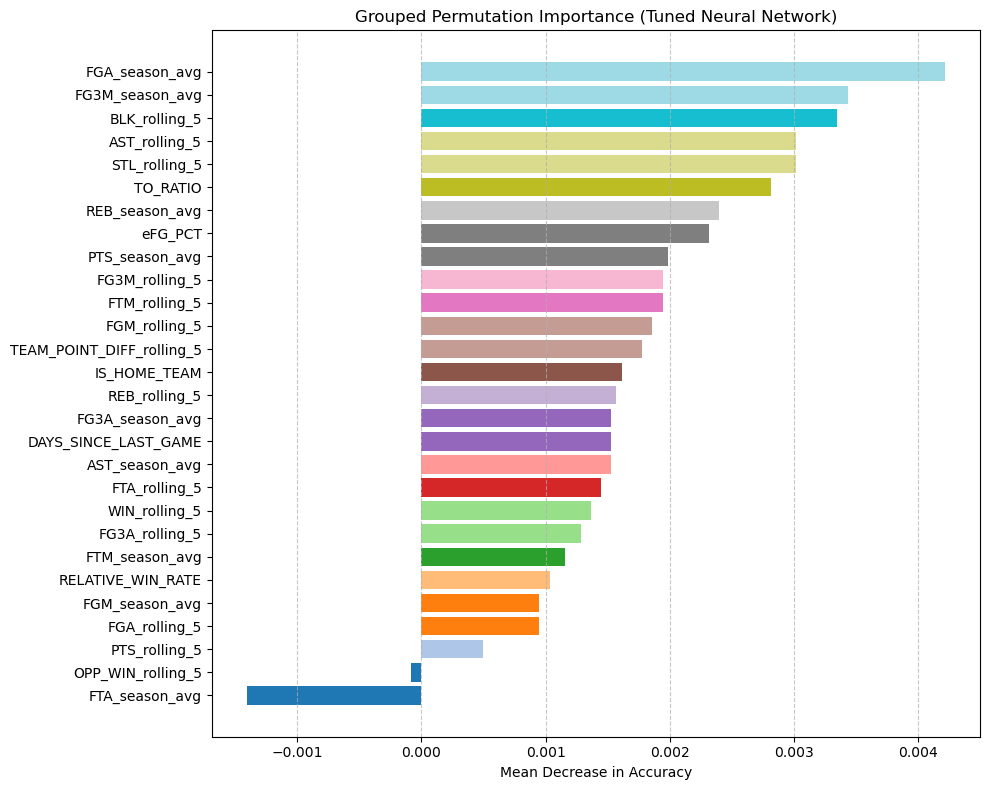

In [45]:
## Expand feature names with time-step suffixes
expanded_feature_names = []
for t in range(window_size):  # window_size=5
    for feature in feature_columns:
        expanded_feature_names.append(f'{feature}_t-{window_size - t}')

## Map base features and average across time steps
base_feature_names = [name.split('_t-')[0] for name in expanded_feature_names]

## Create DataFrame and average
importances_df = pd.DataFrame({
    'feature': base_feature_names,
    'importance': feature_importances
})

grouped_importances = (
    importances_df
    .groupby('feature')['importance']
    .mean()
    .sort_values()
)

## Plot
plt.figure(figsize=(10, 8))
colors = plt.cm.tab20(np.linspace(0, 1, len(grouped_importances)))

plt.barh(
    grouped_importances.index,
    grouped_importances.values,
    color=colors
)
plt.xlabel('Mean Decrease in Accuracy')
plt.title('Grouped Permutation Importance (Tuned Neural Network)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().xaxis.grid(True)
plt.gca().yaxis.grid(False)
plt.tight_layout()
plt.show()